# LSTM Stock Price Prediction Model

## Overview
This notebook implements a Long Short-Term Memory (LSTM) neural network for stock price prediction using **5 key features** that are easy to understand and explain to stakeholders.

## The 5 Key Features

Instead of using only the closing price, our model uses 5 intuitive features:

1. **Close Price** - The actual stock closing price (our main target)
   - What it means: The final price at market close each day
   - Why it matters: Historical prices show trends and patterns

2. **Volume** - Number of shares traded
   - What it means: How many shares were bought/sold that day
   - Why it matters: High volume indicates strong interest/conviction in price moves

3. **20-Day Moving Average (MA20)** - Average price over last 20 days
   - What it means: Smoothed trend line showing general direction
   - Why it matters: Helps identify if stock is trending up or down

4. **Volatility** - How much the price fluctuates
   - What it means: Standard deviation of daily returns over 20 days
   - Why it matters: High volatility = risky/unpredictable, Low volatility = stable

5. **RSI (Relative Strength Index)** - Momentum indicator (0-100)
   - What it means: Measures if stock is overbought (>70) or oversold (<30)
   - Why it matters: Helps predict potential reversals in price direction

## Model Architecture

**Simplified LSTM Design:**
- **2 LSTM Layers** with 64 hidden units each
- **Bidirectional processing** - looks at patterns from both past and future
- **Dropout (20%)** - prevents overfitting to training data
- **Output layer** - predicts next day's closing price

**How it works:**
1. Takes the last 60 days of these 5 features as input
2. LSTM layers learn patterns in the sequential data
3. Outputs a prediction for the next day's closing price

## Why These 5 Features?

- **Price (Close)**: The fundamental data - what we're predicting
- **Volume**: Confirms whether price moves are strong or weak
- **MA20**: Shows the overall trend without daily noise
- **Volatility**: Captures risk and uncertainty in the market
- **RSI**: Identifies potential turning points (reversals)

These 5 features together give the model information about:
- **Trend** (MA20)
- **Momentum** (RSI)
- **Risk** (Volatility)
- **Conviction** (Volume)
- **Price History** (Close)

## Usage
1. Select a stock ticker (default: 'A')
2. Run all cells in order
3. Model trains automatically and shows results
4. Review visualizations to understand predictions

## Important Notes
- **Educational purposes only** - Not financial advice
- **Past performance does not equal future results**
- Model shows what patterns exist in historical data
- Real markets affected by news, earnings, global events not captured here

## Key Parameters
- `n_past = 60`: Uses last 60 days to predict next day
- `hidden_size = 64`: LSTM memory capacity
- `num_layers = 2`: Two LSTM layers
- `dropout = 0.2`: 20% dropout for regularization
- `batch_size = 32`: Training batch size
- `num_epochs = 50`: Training iterations


In [16]:
# Step 0: Import Libraries

import os
import math
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
plt.style.use("seaborn-v0_8")


In [17]:
# enable GPU is running the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [18]:
# Helper Functions for Feature Engineering and Sequence Creation

def calculate_features(df):
    """
    Calculate the 5 key features for stock prediction:
    1. Close - closing price
    2. Volume - trading volume
    3. MA20 - 20-day moving average
    4. Volatility - 20-day standard deviation of returns
    5. RSI - Relative Strength Index (14-day)
    """
    df = df.copy()
    
    # Feature 1: Close price (already in dataset)
    # Feature 2: Volume (already in dataset)
    
    # Feature 3: 20-day Moving Average
    df['MA20'] = df['Close'].rolling(window=20).mean()
    
    # Feature 4: Volatility (standard deviation of daily returns)
    df['Daily_Return'] = df['Close'].pct_change()
    df['Volatility'] = df['Daily_Return'].rolling(window=20).std()
    
    # Feature 5: RSI (Relative Strength Index)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # Drop the intermediate Daily_Return column (not needed as feature)
    df = df.drop('Daily_Return', axis=1)
    
    return df


def create_sequences_multivariate(data, feature_cols, target_col, n_past):
    """
    Create sequences for multivariate LSTM
    
    Args:
        data: DataFrame with all features
        feature_cols: list of column names to use as features
        target_col: name of target column to predict
        n_past: number of past time steps to use as input
    
    Returns:
        X: (num_samples, n_past, num_features)
        y: (num_samples,)
    """
    X, y = [], []
    
    feature_data = data[feature_cols].values
    target_data = data[target_col].values
    
    for i in range(n_past, len(data)):
        X.append(feature_data[i - n_past:i])
        y.append(target_data[i])
    
    return np.array(X), np.array(y)


In [19]:
# Paths relative to project root
DATA_ROOT = "../../data/archive"
Symbols_path = os.path.join(DATA_ROOT, "symbols_valid_meta.csv")

tickers_df = pd.read_csv(Symbols_path)

print("Meta columns:", tickers_df.columns.tolist())
print("Number of symbols in meta:", len(tickers_df))

# Example: A
# May change how to pick the symbol to be done on function call 

target_ticker = "A"

# Find symbol row
row = tickers_df[tickers_df["Symbol"] == target_ticker]
if row.empty:
    raise ValueError(f"Symbol {target_ticker} not found in metadata.")

is_etf = (row["ETF"].iloc[0] == "Y")
asset_type = "etfs" if is_etf else "stocks"

print(f"Selected symbol: {target_ticker} | ETF? {is_etf} | Folder: {asset_type}")


Meta columns: ['Nasdaq Traded', 'Symbol', 'Security Name', 'Listing Exchange', 'Market Category', 'ETF', 'Round Lot Size', 'Test Issue', 'Financial Status', 'CQS Symbol', 'NASDAQ Symbol', 'NextShares']
Number of symbols in meta: 8049
Selected symbol: A | ETF? False | Folder: stocks


In [20]:
#Load data of selected ticker
data_path = os.path.join(DATA_ROOT, asset_type, f"{target_ticker}.csv")
stock_df = pd.read_csv(data_path)
stock_df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,1999-11-18,32.546494,35.765381,28.612303,31.473534,27.068665,62546300
1,1999-11-19,30.713520,30.758226,28.478184,28.880543,24.838577,15234100
2,1999-11-22,29.551144,31.473534,28.657009,31.473534,27.068665,6577800
3,1999-11-23,30.400572,31.205294,28.612303,28.612303,24.607880,5975600
4,1999-11-24,28.701717,29.998211,28.612303,29.372318,25.261524,4843200


In [21]:
# Make sure there is a date column named "Date"
if "Date" not in stock_df.columns:
    if "date" in stock_df.columns:
        stock_df = stock_df.rename(columns={"date": "Date"})
    else:
        raise KeyError("Could not find a 'Date' or 'date' column in the CSV.")

# Ensure we have a closing price column named "Close"
if "Close" not in stock_df.columns:
    # Some datasets use "Adj Close" or "close"
    if "Adj Close" in stock_df.columns:
        stock_df = stock_df.rename(columns={"Adj Close": "Close"})
    elif "close" in stock_df.columns:
        stock_df = stock_df.rename(columns={"close": "Close"})
    else:
        raise KeyError("Could not find a 'Close', 'Adj Close', or 'close' column.")

# Convert Date to datetime and sort chronologically
stock_df["Date"] = pd.to_datetime(stock_df["Date"])
stock_df = stock_df.sort_values("Date").reset_index(drop=True)

print("Date range:", stock_df["Date"].min().date(), "to", stock_df["Date"].max().date())

# Optional: restrict the time window (you can adjust these)
start_date = datetime(2014, 1, 1)
end_date   = datetime(2020, 4, 1)  # e.g., up to April 2020 if using Kaggle archive

mask = (stock_df["Date"] >= start_date) & (stock_df["Date"] <= end_date)
stock_df = stock_df.loc[mask].reset_index(drop=True)


stock_df[["Date", "Close"]].head()


Date range: 1999-11-18 to 2020-04-01


,Date,Close
0,2014-01-02,40.207439
1,2014-01-03,40.715309
2,2014-01-06,40.515022
3,2014-01-07,41.094421
4,2014-01-08,41.766811


In [35]:
# Prepare Dataset with 5 Key Features

# Add the 4 calculated features (Close and Volume already exist)
stock_df = calculate_features(stock_df)

# Drop rows with NaN values (from rolling windows)
stock_df = stock_df.dropna().reset_index(drop=True)

print(f"Data shape after feature engineering: {stock_df.shape}")
print(f"Available columns: {stock_df.columns.tolist()}")

# Select the 5 features for the model
feature_columns = [
    'Close',      # Feature 1: Historical closing prices
    'Volume',     # Feature 2: Trading volume
    'MA20',       # Feature 3: 20-day moving average (trend)
    'Volatility', # Feature 4: Price volatility (risk)
    'RSI'         # Feature 5: Relative Strength Index (momentum)
]

target_column = 'Close'

print(f"\n✓ Using {len(feature_columns)} features for prediction:")
for i, feat in enumerate(feature_columns, 1):
    print(f"  {i}. {feat}")

# Extract data for scaling
dates = stock_df["Date"].values
feature_data = stock_df[feature_columns].values
target_data = stock_df[target_column].values.reshape(-1, 1)

# Scale features and target separately
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

scaled_features = feature_scaler.fit_transform(feature_data)
scaled_target = target_scaler.fit_transform(target_data)

# Chronological split: 80% train / 20% test
train_size = int(len(scaled_features) * 0.8)

train_features = scaled_features[:train_size]
train_target = scaled_target[:train_size]

test_features = scaled_features[train_size:]
test_target = scaled_target[train_size:]

print(f"\nTrain features shape: {train_features.shape}")
print(f"Test features shape: {test_features.shape}")

# Number of past days to use for prediction
n_past = 60

# Create sequences directly from scaled data (no need to combine since Close is already in features)
train_df = pd.DataFrame(train_features, columns=feature_columns)
test_df = pd.DataFrame(test_features, columns=feature_columns)

X_train, y_train = create_sequences_multivariate(train_df, feature_columns, target_column, n_past)
X_test, y_test = create_sequences_multivariate(test_df, feature_columns, target_column, n_past)

val_count = int(len(X_train) * 0.1)
X_val, y_val = X_train[-val_count:], y_train[-val_count:]
X_train, y_train = X_train[:-val_count], y_train[:-val_count]

print(f"\nX_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"Features per timestep: {X_train.shape[2]}")


Data shape after feature engineering: (1513, 10)
Available columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'MA20', 'Volatility', 'RSI']

✓ Using 5 features for prediction:
  1. Close
  2. Volume
  3. MA20
  4. Volatility
  5. RSI

Train features shape: (1210, 5)
Test features shape: (303, 5)

X_train: (1035, 60, 5), y_train: (1035,)
X_val: (115, 60, 5), y_val: (115,)
X_test: (243, 60, 5), y_test: (243,)
Features per timestep: 5


In [36]:
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

X_test_tensor  = torch.from_numpy(X_test).float()
y_test_tensor  = torch.from_numpy(y_test).float()

X_val_tensor  = torch.from_numpy(X_val).float()
y_val_tensor  = torch.from_numpy(y_val).float()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, drop_last=False)


In [24]:
# Simplified LSTM Model

class StockLSTM(nn.Module):
    """
    Simple LSTM model for stock prediction
    
    Architecture:
    - 2 Bidirectional LSTM layers (looks at patterns from past and future)
    - 64 hidden units per layer
    - 20% dropout to prevent overfitting
    - Fully connected output layer
    """
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super(StockLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Bidirectional LSTM
        # Why bidirectional? It learns from both past and future context
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        
        # Output layer
        # Input: hidden_size * 2 (because bidirectional)
        # Output: 1 (predicted price)
        self.fc = nn.Linear(hidden_size * 2, 1)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # x shape: (batch_size, sequence_length, num_features)
        
        # Pass through LSTM layers
        lstm_out, _ = self.lstm(x)
        # lstm_out shape: (batch_size, sequence_length, hidden_size * 2)
        
        # Take the output from the last time step
        last_output = lstm_out[:, -1, :]
        # last_output shape: (batch_size, hidden_size * 2)
        
        # Apply dropout
        last_output = self.dropout(last_output)
        
        # Pass through output layer to get prediction
        prediction = self.fc(last_output)
        # prediction shape: (batch_size, 1)
        
        return prediction.squeeze(-1)  # Remove last dimension


In [25]:
# Training and Evaluation Functions

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)

    return running_loss / len(dataloader.dataset)


def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            preds = model(X_batch)
            loss = criterion(preds, y_batch)

            running_loss += loss.item() * X_batch.size(0)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(y_batch.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    return running_loss / len(dataloader.dataset), all_targets, all_preds


In [27]:
# Initialize Model

num_features = X_train.shape[2]

model = StockLSTM(
    input_size=num_features,   # 5 features
    hidden_size=64,            # 64 memory units per layer
    num_layers=2,              # 2 LSTM layers
    dropout=0.2                # 20% dropout
).to(device)

print(f"\n{'='*60}")
print(f"Model Architecture")
print(f"{'='*60}")
print(f"Input features: {num_features}")
print(f"LSTM layers: 2 (bidirectional)")
print(f"Hidden units: 64 per layer")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"{'='*60}\n")

# Loss function: Mean Squared Error
criterion = nn.MSELoss()

# Optimizer: Adam (adaptive learning rate)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Learning rate scheduler: reduces LR if no improvement
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

num_epochs = 50  # Reduced from 100 for faster training


Model Architecture
Input features: 5
LSTM layers: 2 (bidirectional)
Hidden units: 64 per layer
Total parameters: 135,809



In [ ]:
train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, _, _ = evaluate_model(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Update learning rate based on validation loss
    scheduler.step(val_loss)
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f'best_lstm_{target_ticker}.pth')

    if epoch == 1 or epoch % 5 == 0:
        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")
print(f"\nBest val loss: {best_val_loss:.6f}")
print(f"Model saved as 'best_lstm_{target_ticker}.pth'")


Epoch 001 | Train Loss: 0.034249 | Test Loss: 0.003165
Epoch 005 | Train Loss: 0.001242 | Test Loss: 0.002054
Epoch 010 | Train Loss: 0.000939 | Test Loss: 0.003833
Epoch 015 | Train Loss: 0.000867 | Test Loss: 0.002506
Epoch 020 | Train Loss: 0.000710 | Test Loss: 0.001814
Epoch 025 | Train Loss: 0.000674 | Test Loss: 0.002033
Epoch 030 | Train Loss: 0.000715 | Test Loss: 0.001853
Epoch 035 | Train Loss: 0.000627 | Test Loss: 0.002891
Epoch 040 | Train Loss: 0.000664 | Test Loss: 0.002419
Epoch 045 | Train Loss: 0.000610 | Test Loss: 0.002220
Epoch 050 | Train Loss: 0.000584 | Test Loss: 0.002169

Best test loss: 0.001756
Model saved as 'best_lstm_A.pth'


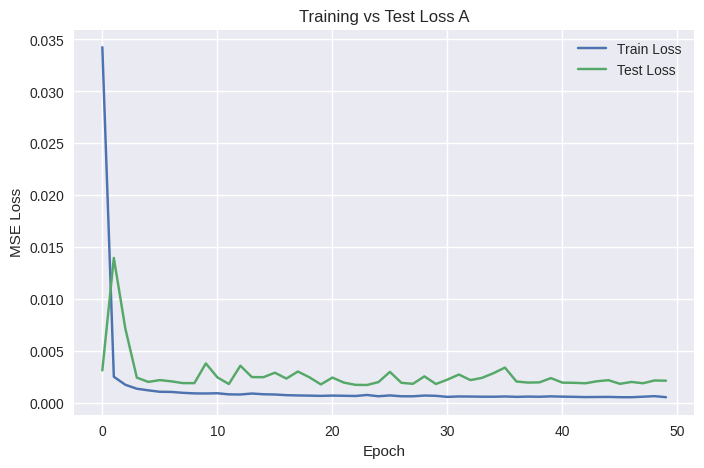

In [29]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title(f"Training vs Test Loss {target_ticker}")
plt.legend()
plt.show()


In [30]:
# Load best model and evaluate
model.load_state_dict(torch.load(f'best_lstm_{target_ticker}.pth'))

train_loss, y_train_true_scaled, y_train_pred_scaled = evaluate_model(
    model, train_loader, criterion, device
)
test_loss, y_test_true_scaled, y_test_pred_scaled = evaluate_model(
    model, test_loader, criterion, device
)

# Inverse transform using target_scaler
y_train_true = target_scaler.inverse_transform(y_train_true_scaled.reshape(-1, 1)).flatten()
y_train_pred = target_scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
y_test_true  = target_scaler.inverse_transform(y_test_true_scaled.reshape(-1, 1)).flatten()
y_test_pred  = target_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

# Calculate multiple metrics
train_rmse = math.sqrt(mean_squared_error(y_train_true, y_train_pred))
test_rmse  = math.sqrt(mean_squared_error(y_test_true,  y_test_pred))

train_mae = np.mean(np.abs(y_train_true - y_train_pred))
test_mae = np.mean(np.abs(y_test_true - y_test_pred))

train_mape = np.mean(np.abs((y_train_true - y_train_pred) / y_train_true)) * 100
test_mape = np.mean(np.abs((y_test_true - y_test_pred) / y_test_true)) * 100

print("=" * 60)
print(f"Performance Metrics for {target_ticker}")
print("=" * 60)
print(f"Train RMSE: ${train_rmse:.4f} | Test RMSE: ${test_rmse:.4f}")
print(f"Train MAE:  ${train_mae:.4f} | Test MAE:  ${test_mae:.4f}")
print(f"Train MAPE: {train_mape:.2f}%  | Test MAPE: {test_mape:.2f}%")
print("=" * 60)


Performance Metrics for A
Train RMSE: $1.1696 | Test RMSE: $2.3786
Train MAE:  $0.8948 | Test MAE:  $1.7539
Train MAPE: 1.80%  | Test MAPE: 2.33%


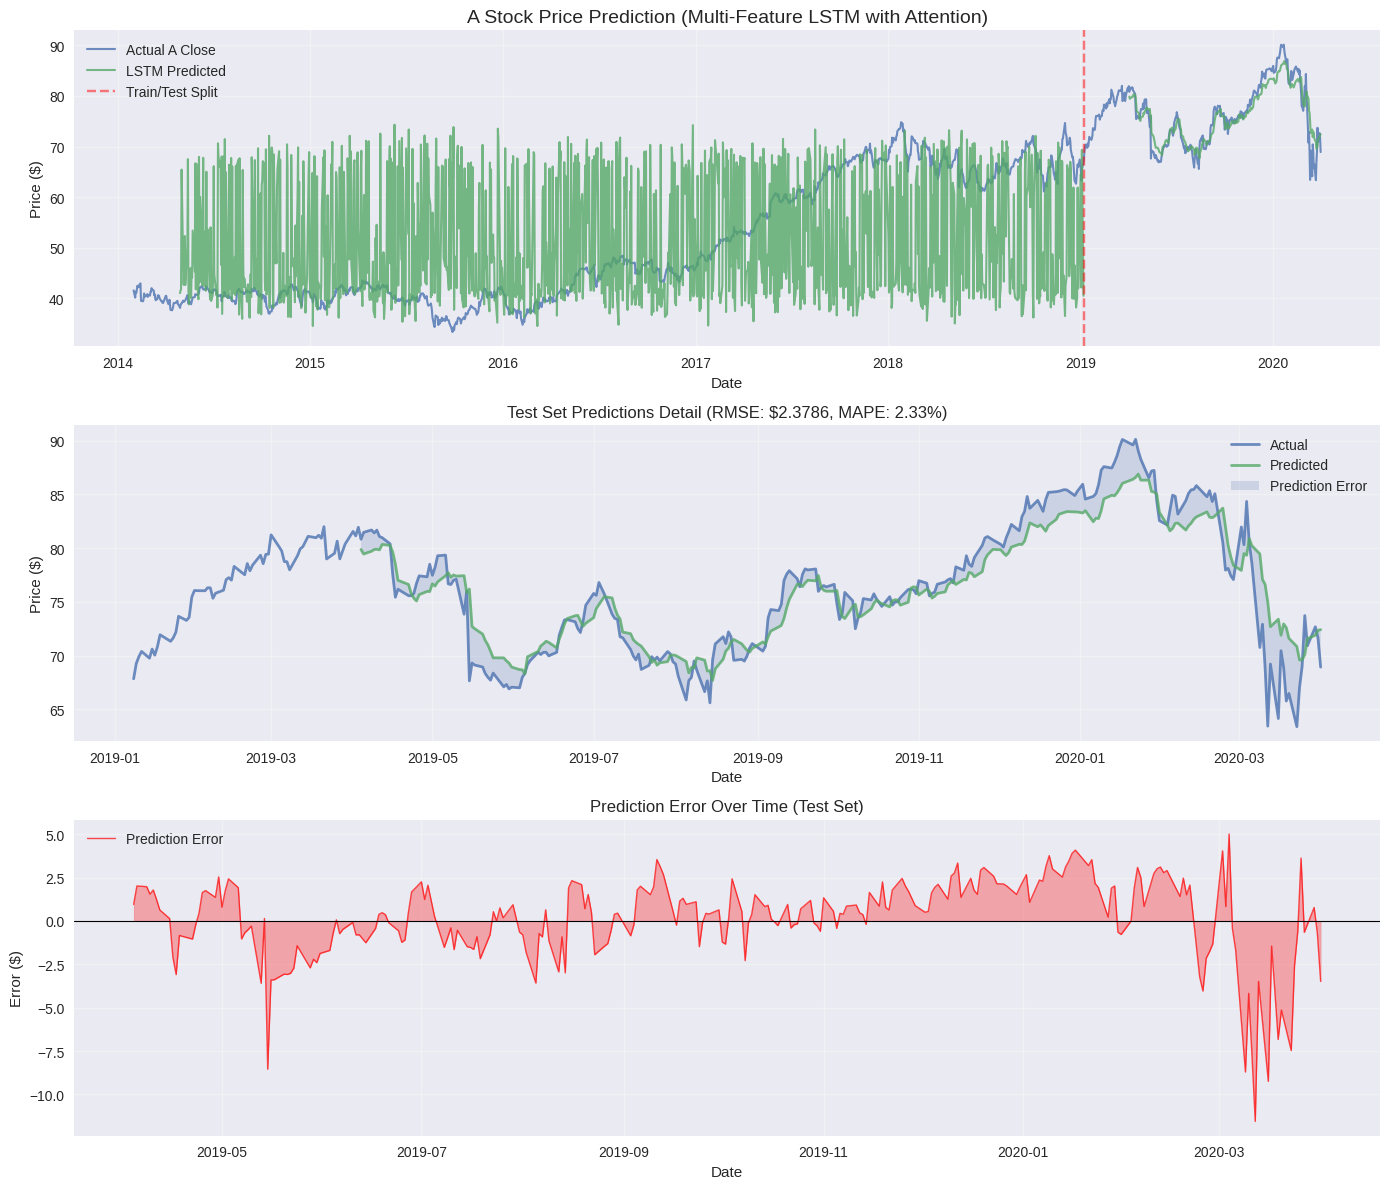

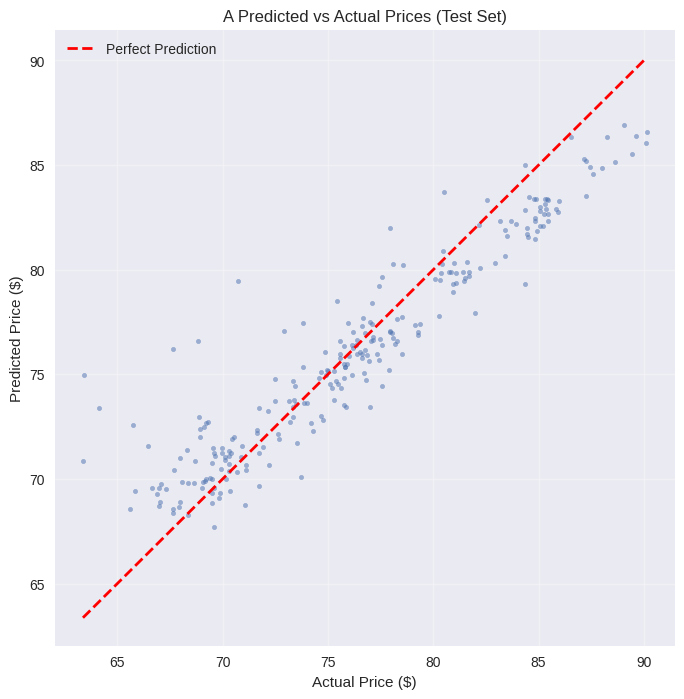

In [31]:
# Enhanced Visualization with Error Metrics

# Get actual prices (before feature engineering dropped some rows)
actual_prices_full = stock_df['Close'].values
dates_full = stock_df['Date'].values

train_full_len = train_size
test_full_len = len(stock_df) - train_size

# Train predictions occupy indices [n_past, train_full_len-1] in the train segment
train_pred_plot = np.empty(train_full_len)
train_pred_plot[:] = np.nan
train_pred_plot[n_past:] = y_train_pred

# Test predictions occupy indices [n_past, test_full_len-1] in the test segment
test_pred_plot = np.empty(test_full_len)
test_pred_plot[:] = np.nan
test_pred_plot[n_past:] = y_test_pred

full_pred = np.empty_like(actual_prices_full)
full_pred[:] = np.nan
full_pred[:train_full_len] = train_pred_plot
full_pred[train_full_len:] = test_pred_plot

# Create comprehensive visualization
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Plot 1: Full predictions
axes[0].plot(dates_full, actual_prices_full, label=f"Actual {target_ticker} Close", linewidth=1.5, alpha=0.8)
axes[0].plot(dates_full, full_pred, label=f"LSTM Predicted", linewidth=1.5, alpha=0.8)
axes[0].axvline(x=dates_full[train_full_len], color='red', linestyle='--', label='Train/Test Split', alpha=0.5)
axes[0].set_title(f"{target_ticker} Stock Price Prediction (Multi-Feature LSTM with Attention)", fontsize=14)
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Price ($)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Test set detail
test_dates = dates_full[train_full_len:]
test_actual = actual_prices_full[train_full_len:]
test_pred_values = full_pred[train_full_len:]

axes[1].plot(test_dates, test_actual, label="Actual", linewidth=2, alpha=0.8)
axes[1].plot(test_dates, test_pred_values, label="Predicted", linewidth=2, alpha=0.8)
axes[1].fill_between(test_dates, test_actual, test_pred_values, alpha=0.2, label='Prediction Error')
axes[1].set_title(f"Test Set Predictions Detail (RMSE: ${test_rmse:.4f}, MAPE: {test_mape:.2f}%)", fontsize=12)
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Price ($)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Prediction error over time
test_dates_valid = test_dates[n_past:]
prediction_error = y_test_true - y_test_pred

axes[2].plot(test_dates_valid, prediction_error, label="Prediction Error", color='red', linewidth=1, alpha=0.7)
axes[2].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[2].fill_between(test_dates_valid, prediction_error, 0, alpha=0.3, color='red')
axes[2].set_title("Prediction Error Over Time (Test Set)", fontsize=12)
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Error ($)")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Scatter plot: Predicted vs Actual
plt.figure(figsize=(8, 8))
plt.scatter(y_test_true, y_test_pred, alpha=0.5, s=10)
plt.plot([y_test_true.min(), y_test_true.max()], 
         [y_test_true.min(), y_test_true.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title(f'{target_ticker} Predicted vs Actual Prices (Test Set)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [32]:
# Query Function for Price Predictions

def query_price_and_trend(date_str, dates_full, actual_prices_full, full_pred, stock_df):
    """
    Simple query function to check predictions for a specific date
    
    Args:
        date_str: Date string (e.g., "2020-03-15")
        dates_full: Array of all dates
        actual_prices_full: Array of actual prices
        full_pred: Array of predicted prices
        stock_df: DataFrame with stock data
    """
    target_date = pd.to_datetime(date_str).normalize()
    first_date = stock_df["Date"].min().normalize()
    last_date = stock_df["Date"].max().normalize()

    # Check if date is before dataset
    if target_date < first_date:
        print(f"Date {date_str} is before the first available date ({first_date.date()}).")
        return

    # Check if date is in dataset
    if target_date <= last_date:
        target_np = np.datetime64(target_date)
        indices = np.where(dates_full == target_np)[0]

        if len(indices) == 0:
            print(f"Date {date_str} not found in the dataset.")
            return

        i = indices[0]
        actual = actual_prices_full[i]
        pred = full_pred[i]

        print(f"\n{'='*60}")
        print(f"{target_ticker} on {date_str}")
        print(f"{'='*60}")
        print(f"Actual close price:     ${actual:.2f}")

        if np.isnan(pred):
            print("No prediction available (in initial 60-day window)")
            return

        print(f"Predicted close price:  ${pred:.2f}")
        error = actual - pred
        error_pct = (error / actual) * 100
        print(f"Prediction error:       ${error:.2f} ({error_pct:+.2f}%)")

        # Show trend
        if i > 0 and not np.isnan(full_pred[i - 1]):
            prev_pred = full_pred[i - 1]
            if pred > prev_pred:
                trend = "UP"
            elif pred < prev_pred:
                trend = "DOWN"
            else:
                trend = "FLAT"
            
            change = pred - prev_pred
            change_pct = (change / prev_pred) * 100
            print(f"Predicted trend:        {trend} (${change:+.2f}, {change_pct:+.2f}%)")
        
        print(f"{'='*60}\n")
    else:
        print(f"\nDate {date_str} is after the dataset.")
        print(f"   Last available date: {last_date.date()}")
        print(f"   Cannot forecast future dates with this simple query.")
        print(f"{'='*60}\n")


In [33]:
# Test the Query Function

print("Testing predictions for different dates:\n")

# Example 1: Historical date
query_price_and_trend("2019-06-03", dates_full, actual_prices_full, full_pred, stock_df)

# Example 2: Another historical date
query_price_and_trend("2020-03-20", dates_full, actual_prices_full, full_pred, stock_df)

# Example 3: Recent date in dataset
query_price_and_trend("2020-03-31", dates_full, actual_prices_full, full_pred, stock_df)


Testing predictions for different dates:


A on 2019-06-03
Actual close price:     $66.99
Predicted close price:  $68.69
Prediction error:       $-1.70 (-2.53%)
Predicted trend:        DOWN ($-0.24, -0.34%)


A on 2020-03-20
Actual close price:     $66.46
Predicted close price:  $71.60
Prediction error:       $-5.14 (-7.73%)
Predicted trend:        DOWN ($-1.00, -1.37%)


A on 2020-03-31
Actual close price:     $71.62
Predicted close price:  $72.35
Prediction error:       $-0.73 (-1.02%)
Predicted trend:        UP ($+0.46, +0.63%)

